In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..') # Add src to path
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import datetime
import h5py
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

import tensorflow as tf

from src.display import get_cmap
from src.utils import make_log_dir

# comment these out if you don't have cartopy
import cartopy.feature as cfeature
from src.display.cartopy import make_ccrs,make_animation

from make_dataset import NowcastGenerator,get_nowcast_train_generator,get_nowcast_test_generator

from unet_benchmark import create_model
from unet_benchmark import nowcast_mae


# Radar Nowcast Challenge

This notebook will describe the SEVIR radar nowcasting challenge.  Nowcasts (https://en.wikipedia.org/wiki/Nowcasting_(meteorology)) are short-term forecast of weather variables typically measured by weather radar or satellite.   Nowcasts are different from traditional weather forecasts (like those you see on the news, or on your phones weather app) in that they are based (mostly) on statistical extrapolations of recent data, rather than full physics-based numerical weather prediction (NWP) models.   The advantages of using statistical extrapolation techniques is that they generally run much faster than NWP models (seconds compared to hours), and because of this, nowcasts are able to  leverage the most recently observed data and use it for forecasting.  Because of this extremely low latency, nowcast out-perform traditional weather models in terms of accuracy and precision for short look-aheads (typically 1-2 hours at most). 

Below is an example a nowcast generated using the baseline model created in this notebook.  The first helf of the movie (Analysis) is observed radar.  The second half of the movie (Forecast) is the predicted located & intensity of the storm.   The challenge is to create the best possible nowcast algorithm given the data in SEVIR.

![imgs/mrms_animation.gif](imgs/mrms_animation.gif)

### Contents:
* [Python environment](#env)
* [Obtaining training & testing dataset](#datasets)
    * [Visualizing training samples](#vistraining)
* [Obtaining training & testing dataset](#baseline)
* [Loading testing and training datasets](#loaddata)
* [Model Training](#training)
* [Visualize Result](#visualize)
* [Forecast Scoring](#scoring)
* [Applying to full-sized images](#fillimgs)

## Python Environment <a class="anchor" id="env"></a>

Running this notebook requires a python environment that includes the modules described here.


## Training and testing datasets <a class="anchor" id="datasets"></a>

This section describes how to extract a training and testing dataset from SEIVR for radar nowcasting.  Make sure you're downloaded the full SEVIR dataset first.  We assume this data is located under `$SEVIR_ROOT`.

Under the directory `$SEVIR_ROOT/data/processed`, you'll see the training and testing datasets in hdf5 format called `radar_nowcast_training.h5` and `radar_nowcast_testing.h5`.  Insepcting these datasets with `h5ls`, you see the contents  






                       



In [9]:
!h5ls ../data/processed/nowcast_training.h5

IN_vil                   Dataset {44760/Inf, 384, 384, 13}
OUT_vil                  Dataset {44760/Inf, 384, 384, 12}


To create this dataset yourself (or to make modifications to the dataset), the command to generate these two files is

```
python make_dataset.py --input_types vil --output_types vil --sevir_data $SEVIR_ROOT/data/ --sevir_catalog $SEVIR_ROOT/CATALOG.csv --output_location ../data/processed/
```

### Visualizing samples in training dataset <a class="anchor" id="vistraining"></a>

The next cells will use the same generator used to create the training data and can also provide metadata for georeferencing and plotting

First create the training data generator used to create the training set.

In [3]:
sevir_root='/home/gridsan/groups/EarthIntelligence/datasets/SEVIR'
sevir = get_nowcast_train_generator(sevir_catalog=sevir_root+'/CATALOG.csv',
                                   batch_size=4, # NOTE: actual batch size will be 3x this
                                   sevir_location=sevir_root+'/data/',
                                   start_date=datetime.datetime(2019,6,1),
                                   end_date=datetime.datetime(2019,7,1),
                                   shuffle=True)


Get a batch of image sequences.  Note the shape `[N,L,L,T]` where `N` is the batch size, `L` is the size of the image patch, and `T` is the number of time steps in the video (1 time step = 5 minutes)

In [4]:
batch_idx = 2 # between 0 and len(sevir)
(X,Y),meta=sevir.get_batch(batch_idx,return_meta=True)
print('Input X:',X[0].shape)
print('Output Y:',Y[0].shape)

Input X: (12, 384, 384, 13)
Output Y: (12, 384, 384, 12)


Now visualize some of the data.  The `meta` variable includes information about how to georeference the patch so we can plot the weather imagery on a map.  This repo also includes some helpful colormaps.  

The following plots a few frames with the custom colormap provided in this repo 

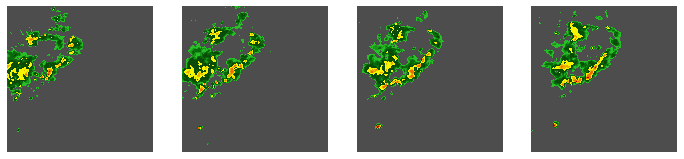

In [5]:
batch_index=2
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,4,figsize=(12,4))
for i in range(4):
    axs[i].imshow(X[0][batch_index,:,:,4*i],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) # every 4th frame
    axs[i].set_axis_off()

The variable `meta` contains the information required to georeference the patches shown here.  If cartopy is installed in your environment, map features can be added to these plots:

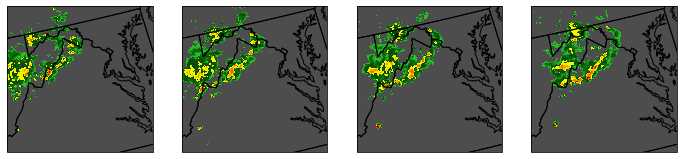

In [6]:
# REQUIRES CARTOPY (and an internet connection if this is your first time using cartopy)
proj,img_extent = make_ccrs(meta.iloc[batch_index])
xll,xur=img_extent[0],img_extent[1]
yll,yur=img_extent[2],img_extent[3]
fig,axs=plt.subplots(1,4,figsize=(12,4), subplot_kw={'projection':proj})
for i in range(4):
    axs[i].set_xlim((xll,xur))
    axs[i].set_ylim((yll,yur))
    axs[i].imshow(X[0][batch_index,:,:,4*i],interpolation='nearest',
                  origin='lower',transform=proj,extent=[xll,xur,yll,yur],
                  cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) # every 4th frame
    axs[i].add_feature(cfeature.STATES)


The function `make_animation` creates a short movie loop:

In [7]:
%%capture off 
anim = make_animation(X[0][2],meta.iloc[2],title='Inputs')
anim.save('imgs/input_animation.gif', writer='imagemagick', fps=6)
anim = make_animation(Y[0][2],meta.iloc[2],title='Target')
anim.save('imgs/output_animation.gif', writer='imagemagick', fps=6)

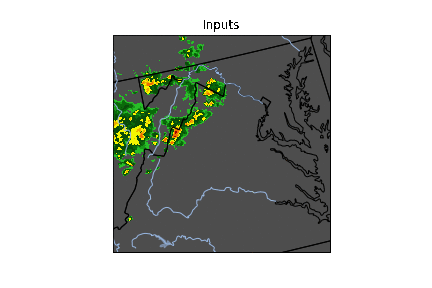

In [8]:
Image('imgs/input_animation.gif')

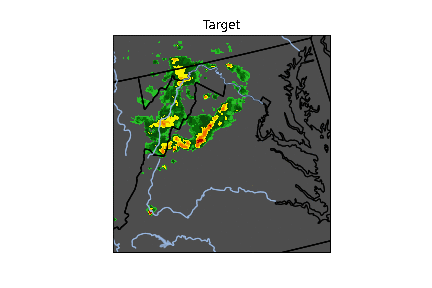

In [9]:
Image('imgs/output_animation.gif')

## Create baseline model<a class="anchor" id="baseline"></a>

The baseline model used in this notebook is the U-Net model based on the model described [here](https://proceedings.neurips.cc//paper/2020/hash/fa78a16157fed00d7a80515818432169-Abstract.html).

This model has the following structure, which takes a sequence of VIL images, and outputs another sequence that covers the next hour of time:
![imgs/unet.png](imgs/unet.png)

Code for the model is defined in `unet_benchmark.py`:

In [109]:
unet = create_model(start_neurons=16) 
unet.summary()

Model: "nowcast_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 13 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 384, 384, 13) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 384, 384, 16) 1888        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 384, 384, 16) 64          conv2d_18[0][0]                  
______________________________________________________________________________________

For a loss function, we'll use mean absolute error scaled by an estimate of the standard deviation computed over the training data ($\sigma=47.54$)
\begin{equation}
L(Y,\hat{Y})=\frac{1}{\sigma}\sum_{i} ||Y-\hat{Y}||_1
\end{equation}

In [110]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
unet.compile(optimizer=opt, loss=nowcast_mae)

## Load training, test datasets <a class="anchor" id="loaddata"></a>

Load training data for training.  The full training set is too large to fi ginito memory, so we will train and test our baseline using `N_TRAIN` and `N_TEST` samples.  Also use `TRAIN_VAL_FRAC * N_TRAIN` training samples for validation

In [111]:
N_TRAIN=5000
TRAIN_VAL_FRAC=0.8
N_TEST=1000

In [11]:
# Loading data takes a few minutes
training_file = '../data/processed/nowcast_training.h5'
testing_file = '../data/processed/nowcast_testing.h5'
with h5py.File(training_file,'r') as hf:
    X_train = hf['IN_vil'][:N_TRAIN]
    Y_train = hf['OUT_vil'][:N_TRAIN]
X_train,X_val=np.split(X_train,[int(TRAIN_VAL_FRAC*N_TRAIN)])
Y_train,Y_val=np.split(Y_train,[int(TRAIN_VAL_FRAC*N_TRAIN)])
        
with h5py.File(training_file,'r') as hf:
    X_test = hf['IN_vil'][:N_TEST]
    Y_test = hf['OUT_vil'][:N_TEST]

## Model training <a class="anchor" id="training"></a>

In this section we train the U-Net model for 10 epochs.


In [112]:
# Training 10 epochs takes around 15-20 minutes on GPU
num_epochs=10
batch_size=8
exprmt_dir=make_log_dir('experiments')

callbacks=[
    tf.keras.callbacks.ModelCheckpoint(exprmt_dir+'/nowcast-unet-{epoch:04d}-{val_loss:04f}.hdf5', 
                    monitor='val_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=exprmt_dir+'/tboardlogs')
]

history = unet.fit(x=X_train, y=Y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                   callbacks=callbacks,
                  validation_data=(X_val, Y_val))

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 55s 14ms/sample - loss: 0.3549 - val_loss: 0.3904
Epoch 2/10
4000/4000 [==============================] - 47s 12ms/sample - loss: 0.2385 - val_loss: 0.1818
Epoch 3/10
4000/4000 [==============================] - 47s 12ms/sample - loss: 0.1972 - val_loss: 0.1957
Epoch 4/10
4000/4000 [==============================] - 47s 12ms/sample - loss: 0.1887 - val_loss: 0.1743
Epoch 5/10
4000/4000 [==============================] - 47s 12ms/sample - loss: 0.1796 - val_loss: 0.1486
Epoch 6/10
4000/4000 [==============================] - 46s 12ms/sample - loss: 0.1723 - val_loss: 0.1491
Epoch 7/10
4000/4000 [==============================] - 46s 12ms/sample - loss: 0.1717 - val_loss: 0.1634
Epoch 8/10
4000/4000 [==============================] - 47s 12ms/sample - loss: 0.1676 - val_loss: 0.1437
Epoch 9/10
4000/4000 [==============================] - 46s 12ms/sample - loss: 0.1655 - val_loss: 0.150

To track progress with tensorboard, start tensorboard in a terminal and port forward via: `ssh -L 6006:localhost:6006 BASTION ssh -L 6006:localhost:6006 -N COMPUTE`
and go to [localhost:6006](localhost:6006)

Plot model training performance for the first 10 epochs

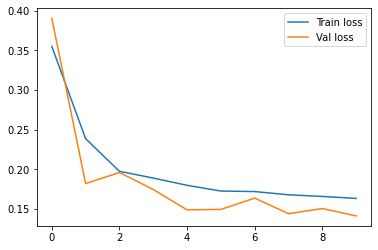

In [113]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.legend()

In [44]:
# save model for later use
unet.save('unet_10epochs.h5')

In [48]:
# Reload previously saved model
unet = tf.keras.models.load_model('unet_10epochs.h5',custom_objects={'nowcast_mae': nowcast_mae})

As can be seen by the above figure, 10 epochs doesn't appear to be enough time for the model to converge.

## Visualize model on test samples <a class="anchor" id="visualize"></a>

Start by visualizing the resulting model


We'll load a pretrained model similar to that trained above, but instead trained for more epochs

In [12]:
from unet_benchmark import nowcast_mae
unet = tf.keras.models.load_model('experiments/201205214743/nowcast-unet-0039-0.133934.hdf5',
                                custom_objects={'nowcast_mae': nowcast_mae})

In [13]:
sevir_root='/home/gridsan/groups/EarthIntelligence/datasets/SEVIR'
sevir_test = get_nowcast_test_generator(sevir_catalog=sevir_root+'/CATALOG.csv',
                                   batch_size=4, # NOTE: actual batch size will be 3x this
                                   sevir_location=sevir_root+'/data/',
                                   start_date=datetime.datetime(2019,6,1),
                                   end_date=datetime.datetime(2019,7,1),
                                   shuffle=True)

In [14]:
(x_test,y_test),meta=sevir_test.get_batch(0,return_meta=True)

In [15]:
%%capture off 
bidx=7
anim = make_animation(x_test[0][bidx],meta.iloc[bidx],title='Inputs')
anim.save('imgs/input_test_animation.gif', writer='imagemagick', fps=6)
anim = make_animation(y_test[0][bidx],meta.iloc[bidx],title='Target')
anim.save('imgs/output_test_animation.gif', writer='imagemagick', fps=6)

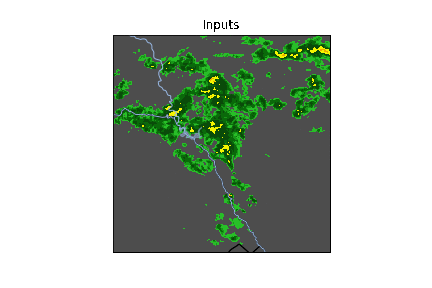

In [16]:
Image('imgs/input_test_animation.gif')

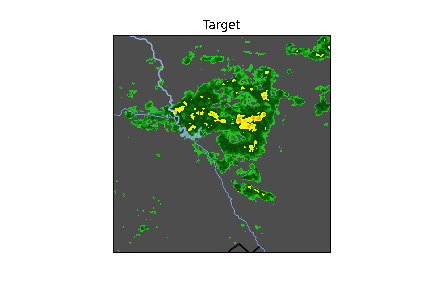

In [17]:
Image('imgs/output_test_animation.gif')

Now compute the prediction

In [18]:
%%capture off 
y_pred = unet.predict(x_test[0])
anim = make_animation(y_pred[bidx],meta.iloc[bidx],title='Prediction')
anim.save('imgs/pred_test_animation.gif', writer='imagemagick', fps=6)

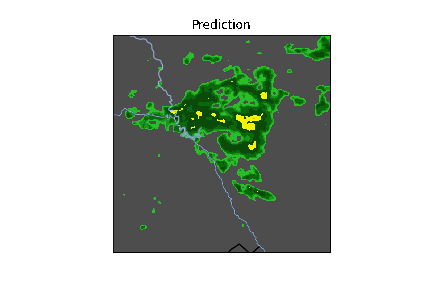

In [19]:
Image('imgs/pred_test_animation.gif')

What do you think?  

The good:
* Seems to be moving the weather in the correct direction, and retaining some of the structure

The bad:
* A lot of the detail becomes washed out, and for longer leads, the more intense sections of the storm decay


## Forecast Scoring <a class="anchor" id="scoring"></a>

Let's apply some more quantitative verifications to establish baseline performance.  

To define metrics used, let $T_i(t)$ and $F_i(t)$ represent target and forecast images, respectively, for test sample $i$ at lead time $t=5,10,...,60$ minutes.  The first metric to consider is mean-absolute error (MAE): 

\begin{equation}
MAE(t) = \frac{1}{L^2 \sigma N_{test}}\sum_{i=1}^{N_{test}} ||T_i(t)-F_i(t)||_1 
\end{equation}

MAE is nice because it is simple, however it often fails to capture forecast skill in predicting fine detail in storm, such as severe storm cores.  Therefore, we'll also apply more standard forecast verification metrics (see [https://www.cawcr.gov.au/projects/verification/](https://www.cawcr.gov.au/projects/verification/)).

Given a threshold $\tau$, we binarize both the traget and forecast images, and label each pixel as a "hit" ($H$) if both target and forecast are $\geq \tau$, a "miss" ($M$) if $T\geq\tau$ and $F<\tau$, a "false alarm" ($FA$) if $T<\tau$ and $F\geq \tau$, and a correct rejection if both $T$ and $F$ are less than $\tau$. 

These pixel scores are rolled up into Critical Success Ratio (CSI) (which is the same as Intersection over Union, which is another common name for this metric) and is computed as 

\begin{equation}
CSI(t;\tau) = \frac{\#H}{\#H + \#M + \#F}
\end{equation}

For scoring VIL nowcasts, we'll average this over three thresholds [16,74,133] representing low, medium, and high strom intensity.  We'll refer to this average as "mCSI", computed for each lead time $t$.

\begin{equation}
mCSI(t) = \frac{1}{3}(CSI(t;16) + CSI(t;74) + CSI(t;133))
\end{equation}

This repo contains some code to compute CSI for the test set.


In [20]:
# Run unet over the test set
y_pred = unet.predict(X_test,batch_size=4)

In [21]:
# Compute metrics over the test set separately for each lead (takes a few minutes)
from tqdm import tqdm
from src.metrics import critical_success_index
CSI = lambda yt,yp,tau: critical_success_index(yt.astype(np.float32),
                                               yp.astype(np.float32),np.array([tau],dtype=np.float32)).numpy()

THRESHOLDS=np.array([16,74,133],dtype=np.float32)
nT=Y_test.shape[3]
mae_t=[]
csi_t = []
for t in tqdm(range(nT)):
    mae_t.append(np.mean(nowcast_mae(Y_test[:,:,:,t:t+1],y_pred[:,:,:,t:t+1])))
    csi_t.append(np.mean([CSI(Y_test[:,:,:,t:t+1], y_pred[:,:,:,t:t+1],tau) for tau in THRESHOLDS]))
    

100%|██████████| 12/12 [01:23<00:00,  6.92s/it]


Text(0.5, 1.0, 'mCSI')

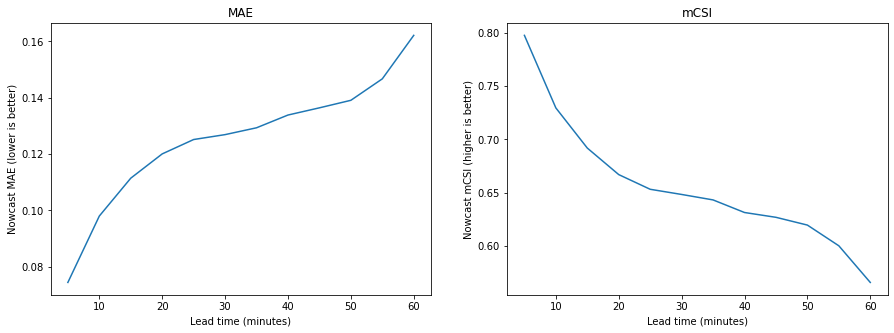

In [34]:
t=np.arange(5,65,5)
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(t,mae_t,label='Nowcast MAE')
ax[0].set_xlabel('Lead time (minutes)')
ax[0].set_ylabel('Nowcast MAE (lower is better)')
ax[0].set_title('MAE')

ax[1].plot(t,csi_t,label='Nowcast mCSI')
ax[1].set_xlabel('Lead time (minutes)')
ax[1].set_ylabel('Nowcast mCSI (higher is better)')
ax[1].set_title('mCSI')


## Applying to full images <a class="anchor" id="fullimgs"></a>

The model trained above is fully convolution and can be apllied to full-sized radar mosaics.  Sample US radar mosaics of VIL can be obtained from [https://mrms.ncep.noaa.gov/data/2D/VIL/](https://mrms.ncep.noaa.gov/data/2D/VIL/) for the past 24 hours.  

These files are in grib2 format.  Before using in the U-Net model, this data needs to be converted to a numpy array, and converted to the [0-255] scale used to train the model above.   [This gist](https://gist.github.com/markveillette/048d7e6b6be35d26bac37378bd66ae01) provides a script for doing this conversion.  To recreate this result, prepare your own MRMS numpy files.


In [93]:
# pick 13 sample files which are 4 minutes apart (SEVIR is 5 minutes apart, close enough)
mrms_root='/home/gridsan/mveillette/data/MRMS/npy'
# UPDATE WITH YOUR OWN FILES
files=[
    'MRMS_CONUS_VIL_00.50_20201125-160039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-160436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-161039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-161442.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-162039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-162434.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-163037.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-163436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-164041.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-164438.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-165039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-165436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-170042.grib2.npy']
vil=[]
for f in files:
    vil.append(np.load(mrms_root+'/'+f)[np.newaxis,:,:,np.newaxis])
vil=np.concatenate(vil,axis=3)
vil = np.pad(vil, ((0,0),(2,2),(4,4),(0,0))) # needed to make sure downsample layers can be done cleanly
m=vil[0:1,2:-2,4:-4,0]==255
vil[vil==255]=0

In [115]:
unet = create_model(start_neurons=16,input_shape=(None,None,13))
unet.load_weights('experiments/201205214743/nowcast-unet-0039-0.133934.hdf5')

In [116]:
# If this overwhelms your GPU, you might need to compute forecast in smaller subsections
forecast = unet.predict(vil)

In [117]:
%%capture off 
import cartopy.crs as crs
from cartopy.crs import Globe
import cartopy.feature as cfeature
from matplotlib import animation, rc
def make_mrms_animation(frames,img_type='vil',fig=None,
                   interval=100,title=None,**kwargs):
    """
    Makes animation of MRMS data
    """
    ellps='WGS84'
    globe=Globe(ellipse=ellps)
    proj=crs.PlateCarree(globe=globe)
    img_extent=(-14471586.0, -6679194.0322265625, 2226397.75, 6122594.1611328125) # MRMS extent
    xll,xur=img_extent[0],img_extent[1]
    yll,yur=img_extent[2],img_extent[3]
    if fig is None:
        fig=plt.gcf()
    ax=fig.add_subplot(1,1,1,projection=proj)
    ax.set_xlim((xll,xur))
    ax.set_ylim((yll,yur))
    cmap,norm,vmin,vmax=get_cmap(img_type)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS )
    
    im=ax.imshow(frames[:,:,0], interpolation='nearest',
          origin='upper', extent=[xll,xur,yll,yur],
          transform=proj,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax);

    def init():
        return (im,)
    def animate(i):
        im.set_data(frames[:,:,i]);
        ftype='Analysis' if i<13 else 'Forecast'
        ax.set_title(ftype)
        return (im,)
    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=range(frames.shape[2]), 
                                   interval=interval, blit=True);

frames = np.concatenate((vil[:,2:-2,4:-4,:],forecast[:,2:-2,4:-4,:]),axis=3)
for i in range(frames.shape[3]):
    frames[:,:,:,i][m]=np.nan
plt.figure(figsize=(15,7))
anim = make_mrms_animation(frames[0])
anim.save('imgs/mrms_animation.gif', writer='imagemagick', fps=6)

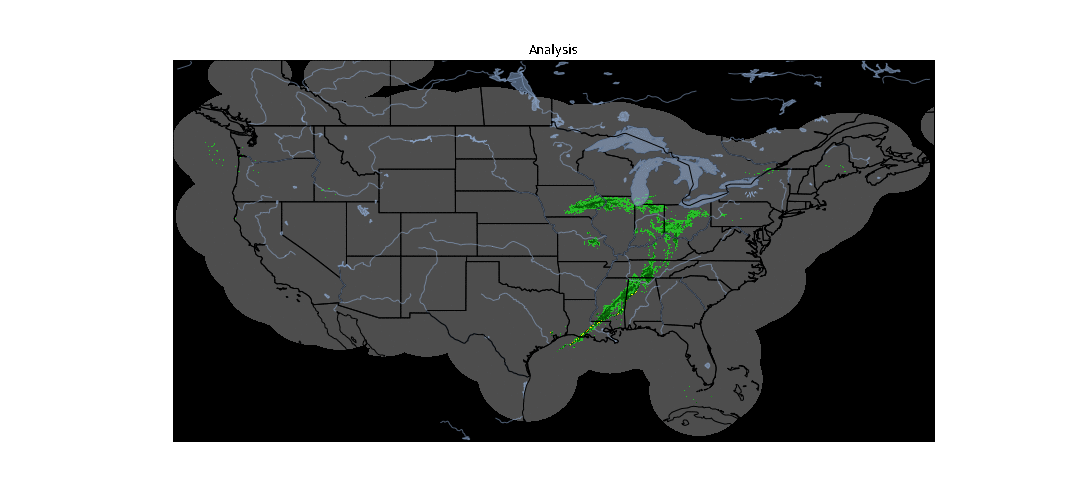

In [118]:
Image('imgs/mrms_animation.gif')